# VTI elastic with a sinusoid boundary

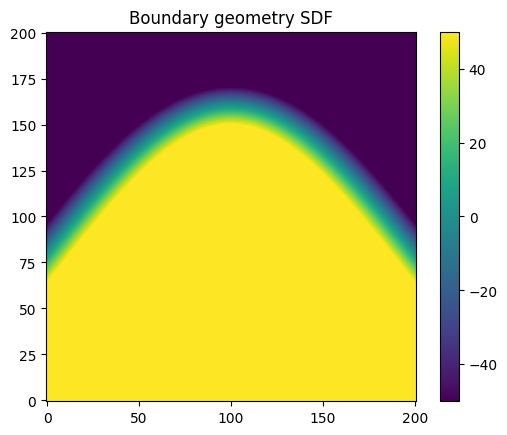

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sinusoid 2D sdf
sdf = read_sdf('sinusoid_new_hi_res', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry
bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


In [3]:
import devito as dv

s_o = 4

ux = dv.TimeFunction(name='ux', grid=grid, space_order=s_o, time_order=2)
uy = dv.TimeFunction(name='uy', grid=grid, space_order=s_o, time_order=2)

# Material parameters
v_p0 = 1.
v_s0 = 0.65
de = 0.1
ep = 0.25

v_p02 = v_p0**2
v_s02 = v_s0**2
v_pn2 = (1+2*de)*v_p0**2
v_px2 = (1+2*ep)*v_p0**2

In [4]:
from schism import BoundaryConditions

nx = bg.n[0]
ny = bg.n[1]

# More shorthands
v_p04 = v_p0**4
v_s04 = v_s0**4

# Note that a factor of rho has been removed here
txx = v_px2*ux.dx \
    + np.sqrt((v_p02-v_s02)*(v_pn2-v_s02))*uy.dy - v_s02*uy.dy
tyy = np.sqrt((v_p02-v_s02)*(v_pn2-v_s02))*uy.dy - v_s02*ux.dx \
    + v_p02*uy.dy
txy = v_s02*ux.dy + v_s02*uy.dx

# With fourth-order boundary conditions
bc_list = [dv.Eq(nx*txx + ny*txy, 0),
           dv.Eq(nx*txy + ny*tyy, 0),
           dv.Eq(nx*ux.dx3*v_pn2*v_px2
                 + ny*ux.dy3*v_s04
                 + ny*uy.dx3*v_pn2*v_s02
                 + ny*ux.dx2dy*(v_p02*v_pn2 - v_p02*v_s02 + v_s04
                                - v_s02*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                                - v_pn2*v_s02 + v_s04))
                 + nx*ux.dxdy2*(v_px2*v_s02
                                + v_s02*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                                - v_pn2*v_s02 + v_s04))
                 + nx*uy.dx2dy*(-v_pn2*v_s02
                                + v_pn2*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                                - v_pn2*v_s02 + v_s04)
                                + v_s02*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                                - v_pn2*v_s02 + v_s04))
                 + ny*uy.dxdy2*(v_p02*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                              - v_pn2*v_s02 + v_s04)
                                + v_s04)
                 + nx*uy.dy3*(-v_s04
                              + v_s02*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                              - v_pn2*v_s02 + v_s04)), 0),
          dv.Eq(nx*ux.dy3*v_p02*v_s02
                + nx*uy.dx3*v_s04
                + ny*uy.dy3*v_p04
                + nx*ux.dx2dy*(v_px2*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                             - v_pn2*v_s02 + v_s04)
                               + v_s04)
                + ny*ux.dx3*(-v_s04
                             + v_s02*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                             - v_pn2*v_s02 + v_s04))
                + ny*ux.dxdy2*(-v_p02*v_s02
                               + v_p02*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                               - v_pn2*v_s02 + v_s04)
                               + v_s02*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                               - v_pn2*v_s02 + v_s04))
                + ny*uy.dx2dy*(v_p02*v_s02
                               + v_s02*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                               - v_pn2*v_s02 + v_s04))
                + nx*uy.dxdy2*(v_p02*v_pn2 - v_pn2*v_s02 + v_s04
                               - v_s02*np.sqrt(v_p02*v_pn2 - v_p02*v_s02
                                               - v_pn2*v_s02 + v_s04)), 0)]

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

derivs = (ux.dx2, ux.dy2, ux.dxdy, uy.dx2, uy.dy2, uy.dxdy)

subs = boundary.substitutions(derivs)

Generating stencils for Derivative(ux(t, x, y), (x, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(ux(t, x, y), (y, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(ux(t, x, y), x, y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), (x, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), (y, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), x, y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


In [6]:
from examples.seismic import TimeAxis, RickerSource

# Reset the fields
ux.data[:] = 0
uy.data[:] = 0

t0 = 0.  # Simulation starts a t=0
tn = 650.  # Simulation last 0.65 seconds (650 ms)
dt = 0.5*grid.spacing[0]/v_p0  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.012  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 500.

In [7]:
rhs_ux = v_px2*ux.dx2 + v_s02*ux.dy2 + np.sqrt((v_p02-v_s02)*(v_pn2-v_s02))*uy.dxdy
rhs_uy = v_s02*uy.dx2 + v_p02*uy.dy2 + np.sqrt((v_p02-v_s02)*(v_pn2-v_s02))*ux.dxdy

eq_ux = dv.Eq(ux.forward,
              2*ux - ux.backward
              + dt**2*rhs_ux.subs(subs))

eq_uy = dv.Eq(uy.forward,
              2*uy - uy.backward
              + dt**2*rhs_uy.subs(subs))

In [8]:
src_ux = src.inject(field=ux.forward, expr=src*dt**2)
src_uy = src.inject(field=uy.forward, expr=-src*dt**2)

In [9]:
op = dv.Operator([eq_ux, eq_uy] + src_ux)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 4.40 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=4.398181000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00020799999999999955, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

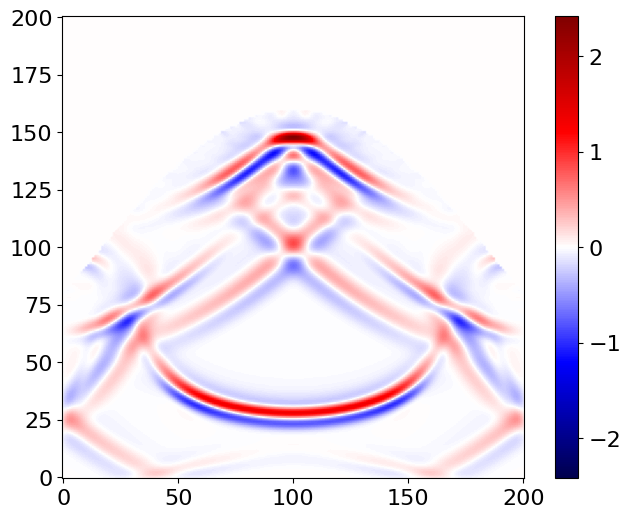

In [10]:
plt.imshow(ux.data[1].T, origin='lower', cmap='seismic',
           vmax=np.amax(np.abs(ux.data[1])), vmin=-np.amax(np.abs(ux.data[1])))
plt.colorbar()
plt.show()

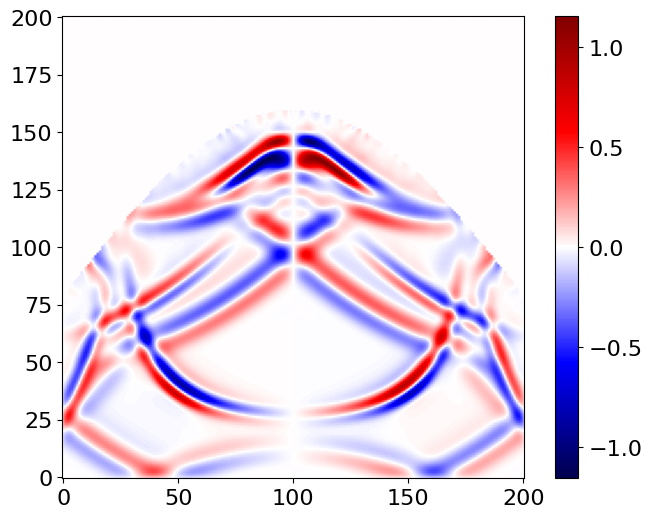

In [11]:
plt.imshow(uy.data[1].T, origin='lower', cmap='seismic',
           vmax=np.amax(np.abs(uy.data[1])), vmin=-np.amax(np.abs(uy.data[1])))
plt.colorbar()
plt.show()

In [12]:
assert np.isclose(np.linalg.norm(ux.data), 74.69499)
assert np.isclose(np.linalg.norm(uy.data), 58.845886)